[@LorenaABarba](https://twitter.com/LorenaABarba)

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

***12 étapes vers Navier–Stokes***
======
***

Nous continuons notre voyage pour résoudre l'équation de Navier-Stokes avec l'étape 4. Mais ne continuez pas avant d'avoir terminé les étapes précédentes ! En fait, cette prochaine étape sera une combinaison des deux précédentes. Les merveilles de la *réutilisation du code* !

Étape 4 : Équation de Burgers
----
***

Vous pouvez en savoir plus sur l'équation de Burgers sur sa [page wikipedia](http://en.wikipedia.org/wiki/Burgers'_equation).

L'équation de Burgers dans une dimension spatiale ressemble à ceci :

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial ^2u}{\partial x^2}$$

Comme vous pouvez le voir, c'est une combinaison de convection non linéaire et de diffusion. Il est surprenant de voir tout ce que vous apprenez de cette petite équation soignée !

Nous pouvons le discrétiser en utilisant les méthodes que nous avons déjà détaillées dans les étapes [1](./01_Step_1.ipynb) à [3](./04_Step_3.ipynb). En utilisant la différence avant pour le temps, la différence arrière pour l'espace et notre méthode du 2e ordre pour les dérivées secondes, on obtient :

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

Comme précédemment, une fois que nous avons une condition initiale, la seule inconnue est $u_i^{n+1}$. Nous avancerons dans le temps comme suit :

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\ Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

### Conditions initiales et aux limites

Pour examiner certaines propriétés intéressantes de l'équation de Burgers, il est utile d'utiliser des conditions initiales et aux limites différentes de celles que nous avons utilisées pour les étapes précédentes.

Notre condition initiale pour ce problème va être :

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu } \bigg)
\end{eqnarray}

Celle-ci admet une solution analytique, donnée par :

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t - 2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}

Notre condition aux limites sera :

$$u(0) = u(2\pi)$$

C'est ce qu'on appelle une condition aux limites *périodique*. Faites attention! Cela vous causera un peu de mal de tête si vous ne faites pas attention.

### Gain de temps avec SymPy


La condition initiale que nous utilisons pour l'équation de Burgers peut être un peu pénible à évaluer à la main. La dérivée $\frac{\partial \phi}{\partial x}$ n'est pas trop difficile, mais il serait facile de laisser tomber un signe ou d'oublier un facteur de $x$ quelque part, donc nous allons utiliser SymPy pour nous aider.

[SymPy](http://sympy.org/en/) est la bibliothèque mathématique symbolique pour Python. Il a beaucoup des mêmes fonctionnalités mathématiques symboliques que Mathematica avec l'avantage supplémentaire que nous pouvons facilement traduire ses résultats dans nos calculs Python (il est également gratuit et open source).

Commencez par charger la bibliothèque SymPy, ainsi que notre bibliothèque préférée, NumPy.

In [2]:
import numpy
import sympy

Nous allons également dire à SymPy que nous voulons que toute sa sortie soit rendue en utilisant $\LaTeX$. Cela rendra notre cahier magnifique !

In [3]:
from sympy import init_printing
init_printing(use_latex=True)

Start by setting up symbolic variables for the three variables in our initial condition and then type out the full equation for $\phi$.  We should get a nicely rendered version of our $\phi$ equation.

In [4]:
x, nu, t = sympy.symbols('x nu t')
phi = (sympy.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sympy.exp(-(x - 4 * t - 2 * sympy.pi)**2 / (4 * nu * (t + 1))))
phi

C'est peut-être un peu petit, mais ça a l'air correct. Maintenant, évaluer notre dérivée partielle $\frac{\partial \phi}{\partial x}$ est une tâche triviale.

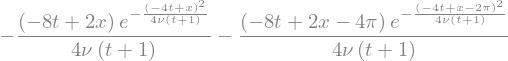

In [5]:
phiprime = phi.diff(x)
phiprime

Si vous voulez voir la version non rendue, utilisez simplement la commande d'impression Python.

In [6]:
print(phiprime)

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


### Maintenant quoi?

Maintenant que nous avons la version Pythonic de notre dérivée, nous pouvons finir d'écrire l'équation complète de la condition initiale, puis la traduire en une expression Python utilisable. Pour cela, nous utiliserons la fonction *lambdify*, qui prend une équation symbolique SymPy et la transforme en une fonction appelable.

In [7]:
from sympy.utilities.lambdify import lambdify

u = -2 * nu * (phiprime / phi) + 4
print(u)

-2*nu*(-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)))/(exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1))) + exp(-(-4*t + x)**2/(4*nu*(t + 1)))) + 4


### Lambdifier

Pour lambdifier cette expression dans une fonction utilisable, nous indiquons à lambdify quelles variables demander et la fonction à laquelle nous voulons les connecter.

In [8]:
ufunc = lambdify((t, x, nu), u)
print(ufunc(1, 4, 3))

3.49170664206445


### Retour à l'équation de Burgers
Maintenant que nous avons défini les conditions initiales, nous pouvons continuer et terminer la configuration du problème. Nous pouvons générer le tracé de la condition initiale en utilisant notre fonction lambdifiée.

In [9]:
from matplotlib import pyplot
%matplotlib inline

###variable declarations
nx = 101
nt = 100
dx = 2 * numpy.pi / (nx - 1)
nu = .07
dt = dx * nu

x = numpy.linspace(0, 2 * numpy.pi, nx)
un = numpy.empty(nx)
t = 0

u = numpy.asarray([ufunc(t, x0, nu) for x0 in x])
u

array([4.        , 4.06283185, 4.12566371, 4.18849556, 4.25132741,
       4.31415927, 4.37699112, 4.43982297, 4.50265482, 4.56548668,
       4.62831853, 4.69115038, 4.75398224, 4.81681409, 4.87964594,
       4.9424778 , 5.00530965, 5.0681415 , 5.13097336, 5.19380521,
       5.25663706, 5.31946891, 5.38230077, 5.44513262, 5.50796447,
       5.57079633, 5.63362818, 5.69646003, 5.75929189, 5.82212374,
       5.88495559, 5.94778745, 6.0106193 , 6.07345115, 6.136283  ,
       6.19911486, 6.26194671, 6.32477856, 6.38761042, 6.45044227,
       6.51327412, 6.57610598, 6.63893783, 6.70176967, 6.76460125,
       6.82742866, 6.89018589, 6.95176632, 6.99367964, 6.72527549,
       4.        , 1.27472451, 1.00632036, 1.04823368, 1.10981411,
       1.17257134, 1.23539875, 1.29823033, 1.36106217, 1.42389402,
       1.48672588, 1.54955773, 1.61238958, 1.67522144, 1.73805329,
       1.80088514, 1.863717  , 1.92654885, 1.9893807 , 2.05221255,
       2.11504441, 2.17787626, 2.24070811, 2.30353997, 2.36637

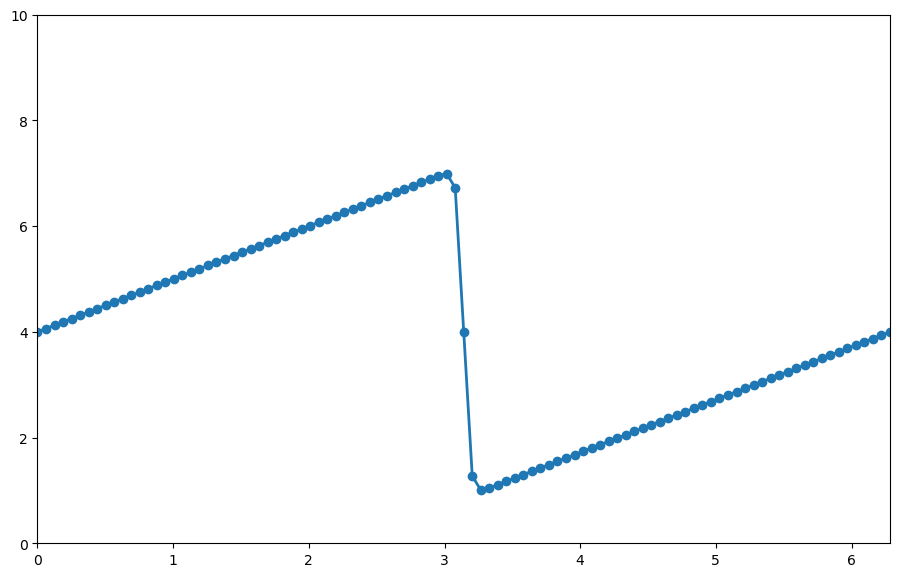

In [10]:
pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.plot(x, u, marker='o', lw=2)
pyplot.xlim([0, 2 * numpy.pi])
pyplot.ylim([0, 10]);

Ce n'est certainement pas la fonction de chapeau à laquelle nous avons eu affaire jusqu'à présent. Nous appelons cela une "fonction en dents de scie". Avançons et voyons ce qui se passe. 

### Conditions aux limites périodiques

L'une des grandes différences entre l'étape 4 et les leçons précédentes est l'utilisation de conditions aux limites *périodiques*. Si vous expérimentez les étapes 1 et 2 et que la simulation s'exécute plus longtemps (en augmentant `nt`), vous remarquerez que l'onde continuera de se déplacer vers la droite jusqu'à ce qu'elle n'apparaisse plus dans le tracé.

Avec des conditions aux limites périodiques, lorsqu'un point arrive sur le côté droit du cadre, il *s'enroule* vers l'avant du cadre.

Rappelons la discrétisation que nous avons élaborée au début de ce cahier :

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\ Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

Qu'est-ce que $u_{i+1}^n$ *signifie* lorsque $i$ est déjà à la fin de la trame ?

Réfléchissez-y une minute avant de continuer.



In [11]:
for n in range(nt):
    un = u.copy()
    for i in range(1, nx-1):
        u[i] = un[i] - un[i] * dt / dx *(un[i] - un[i-1]) + nu * dt / dx**2 *\
                (un[i+1] - 2 * un[i] + un[i-1])
    u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 *\
                (un[1] - 2 * un[0] + un[-2])
    u[-1] = u[0]
        
u_analytical = numpy.asarray([ufunc(nt * dt, xi, nu) for xi in x])

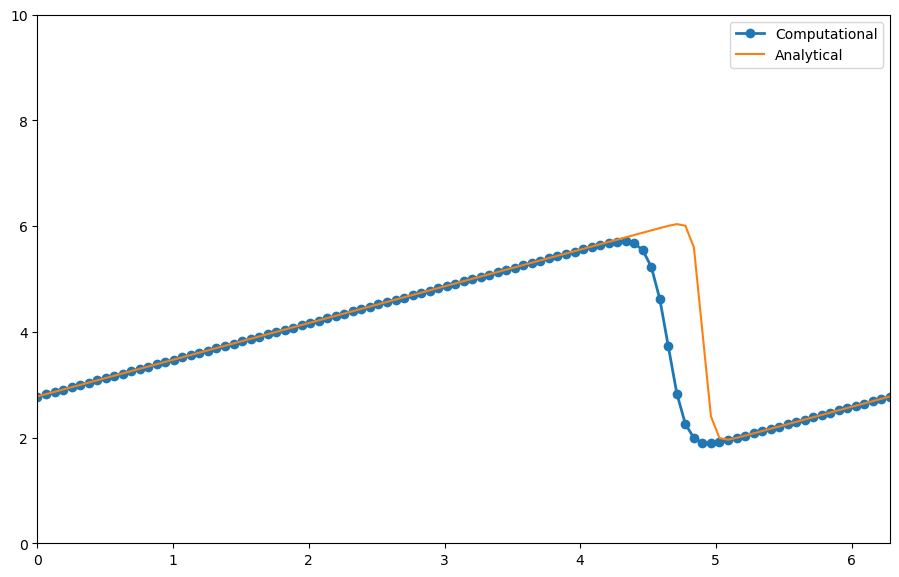

In [12]:
pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.plot(x,u, marker='o', lw=2, label='Computational')
pyplot.plot(x, u_analytical, label='Analytical')
pyplot.xlim([0, 2 * numpy.pi])
pyplot.ylim([0, 10])
pyplot.legend();

***

Et ensuite ?
----

Les étapes suivantes, de 5 à 12, seront en deux dimensions. Mais il est facile d'étendre les formules aux différences finies 1D aux dérivées partielles en 2D ou 3D. Appliquez simplement la définition — une dérivée partielle par rapport à $x$ est la variation dans la direction $x$ *tout en gardant $y$ constant*.

Avant de passer à l'[Étape 5](./07_Step_5.ipynb), assurez-vous d'avoir terminé votre propre code pour les étapes 1 à 4 et d'avoir expérimenté les paramètres et réfléchi à ce qui se passe. Nous vous recommandons également de faire une petite pause pour en savoir plus sur les [opérations sur les tableaux avec NumPy](./06_Array_Operations_with_NumPy.ipynb).

In [13]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()